In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Read the dataset
crop_data = pd.read_csv('Crop_Data.csv')

# Data Cleaning 
crop_data = crop_data.drop(columns=['Note', 'Flag Description', 'Flag', 'Year Code'])

# Impute missing 'Unit' and 'Item Code (CPC)'
crop_data['Unit'] = crop_data['Unit'].fillna(crop_data['Unit'].mode()[0])  # Mode for categorical data
crop_data['Item Code (CPC)'] = crop_data['Item Code (CPC)'].ffill()  

# Impute missing 'Value' using median instead of mean
crop_data['Value'] = crop_data['Value'].fillna(crop_data['Value'].median())

# Data Transformation
df = crop_data.pivot_table(
    index=['Domain', 'Area Code (M49)', 'Area', 'Item Code (CPC)', 'Item', 'Year'],
    columns='Element',
    values='Value',
    aggfunc='first'
).reset_index()

missing = df.isnull().sum()
percentage = (df.isnull().sum() / len(df)) * 100
#print("Missing crop_data Counts:\n", missing)
print("\nMissing crop_data Percentage:\n",percentage)

# Drop unnecessary columns properly
df = df.drop(columns=['Area Code (M49)', 'Stocks', 'Yield/Carcass Weight','Item Code (CPC)'])
df = df.drop(columns=['Laying', 'Milk Animals', 'Producing Animals/Slaughtered'], errors='ignore')

# Sort before forward fill
df = df.sort_values(by=['Item', 'Year'])

# Fill missing values
df['Area harvested'] = df['Area harvested'].fillna(df['Area harvested'].median())
df['Yield'] = df['Yield'].ffill()  # Use .ffill() instead of method='ffill'
df['Production'] = df['Production'].fillna(df['Production'].median())

# Save the transformed data
df.to_csv('Updated_data.csv', index=False)

missing = df.isnull().sum()
percentage = (df.isnull().sum() / len(df)) * 100
#print("Missing crop_data Counts:\n", missing)
print("\nMissing crop_data Percentage:\n",percentage)




Missing crop_data Percentage:
 Element
Domain                            0.000000
Area Code (M49)                   0.000000
Area                              0.000000
Item Code (CPC)                   0.000000
Item                              0.000000
Year                              0.000000
Area harvested                   47.554912
Laying                           98.885611
Milk Animals                     97.762882
Producing Animals/Slaughtered    81.174226
Production                       11.075088
Stocks                           90.816975
Yield                            47.279702
Yield/Carcass Weight             93.425209
dtype: float64

Missing crop_data Percentage:
 Element
Domain            0.0
Area              0.0
Item              0.0
Year              0.0
Area harvested    0.0
Production        0.0
Yield             0.0
dtype: float64


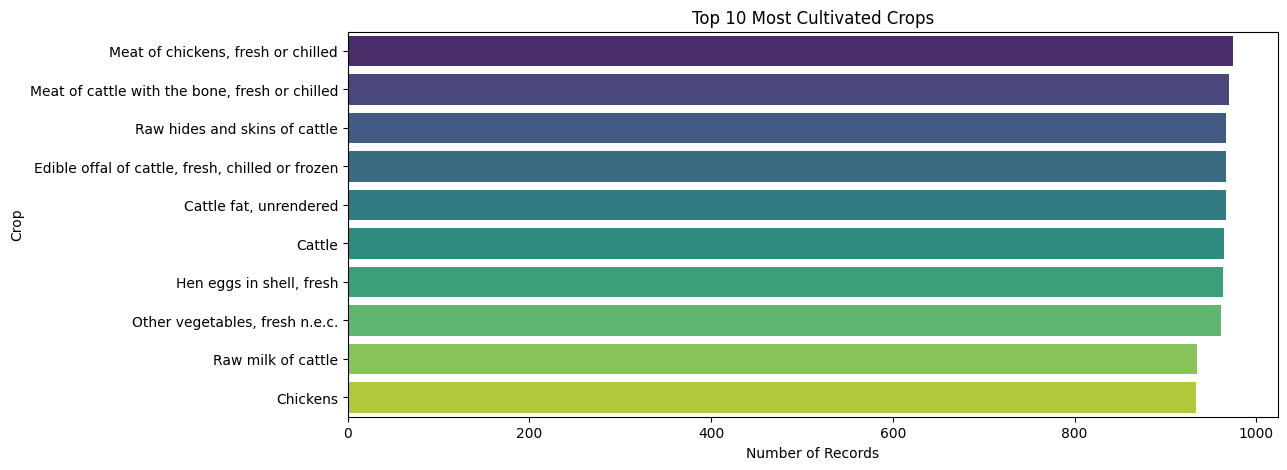

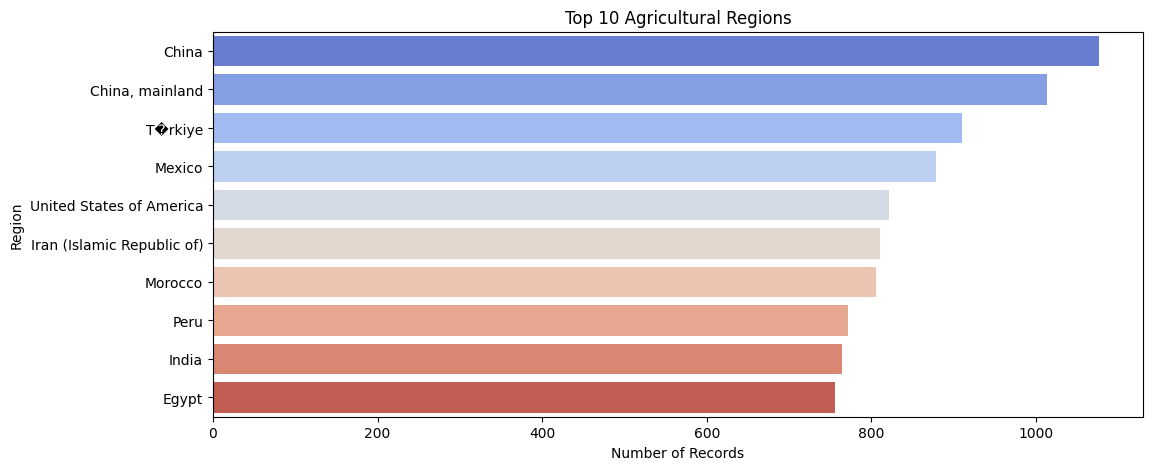

In [2]:
# EDA analysis

# Most & Least Cultivated Crops 
# Count occurrences of each crop
crop_counts = df['Item'].value_counts()

# Top 10 most cultivated crops
top_crops = crop_counts.head(10)

# Bottom 10 least cultivated crops
least_crops = crop_counts.tail(10)

# Plot crop distribution
plt.figure(figsize=(12, 5))
sns.barplot(x=top_crops.values, y=top_crops.index, palette='viridis', hue=top_crops.index, legend=False)
plt.xlabel("Number of Records")
plt.ylabel("Crop")
plt.title("Top 10 Most Cultivated Crops")
plt.show()

# Geographical Distribution 
# Count occurrences of each region
region_counts = df['Area'].value_counts()

# Top 10 agricultural regions
top_regions = region_counts.head(10)

# Plot geographical distribution
plt.figure(figsize=(12, 5))
sns.barplot(x=top_regions.values, y=top_regions.index, palette='coolwarm', hue=top_regions.index, legend=False)
plt.xlabel("Number of Records")
plt.ylabel("Region")
plt.title("Top 10 Agricultural Regions")
plt.show()


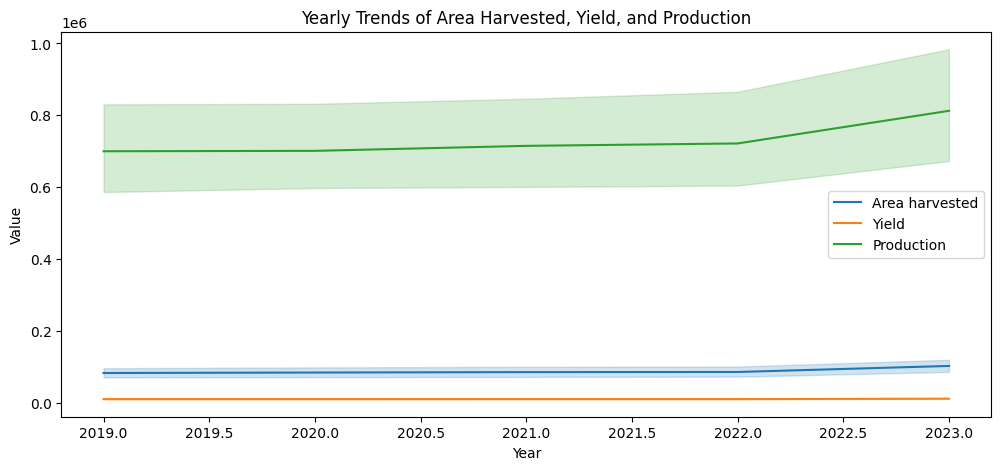

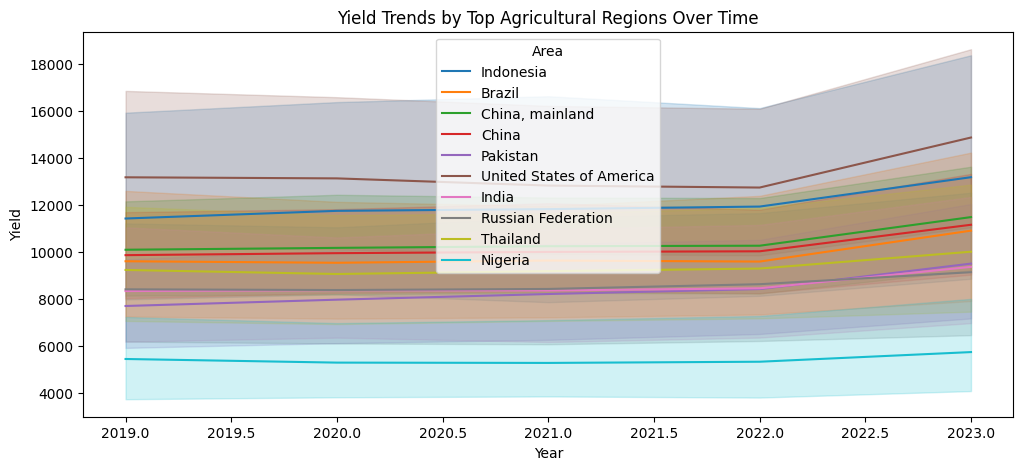

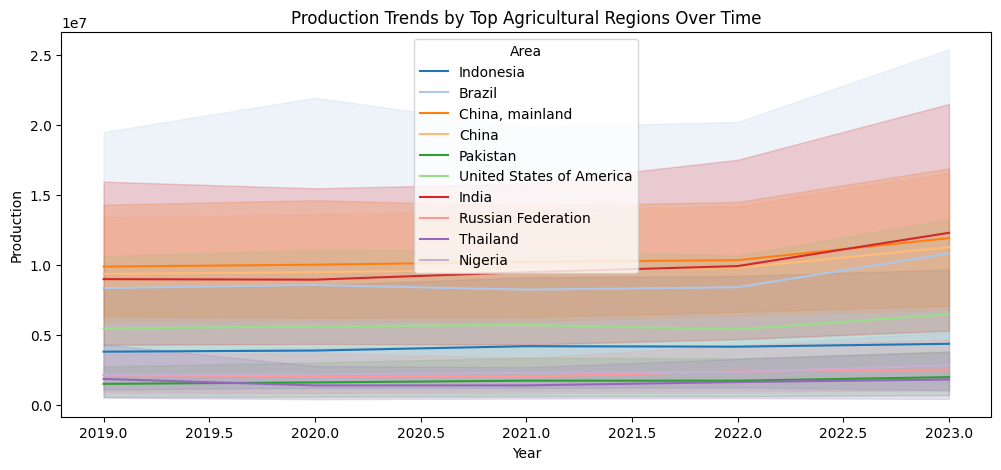

In [3]:
#Temporal Analysis
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x="Year", y="Area harvested", label="Area harvested")
sns.lineplot(data=df, x="Year", y="Yield", label="Yield")
sns.lineplot(data=df, x="Year", y="Production", label="Production")
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Yearly Trends of Area Harvested, Yield, and Production")
plt.legend()
plt.show()

#Growth Analysis
# Identify top agricultural regions based on total production
top_regions = df.groupby("Area")["Production"].sum().nlargest(10)  # Top 10 regions
filtered_df = df[df["Area"].isin(top_regions.index)]

# Yield Trends by Top Agricultural Regions Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(data=filtered_df, x="Year", y="Yield", hue="Area", palette="tab10")
plt.xlabel("Year")
plt.ylabel("Yield")
plt.title("Yield Trends by Top Agricultural Regions Over Time")
plt.legend(title="Area")
plt.show()

# Production Trends by Top Agricultural Regions Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(data=filtered_df, x="Year", y="Production", hue="Area", palette="tab20")
plt.xlabel("Year")
plt.ylabel("Production")
plt.title("Production Trends by Top Agricultural Regions Over Time")
plt.legend(title="Area")
plt.show()

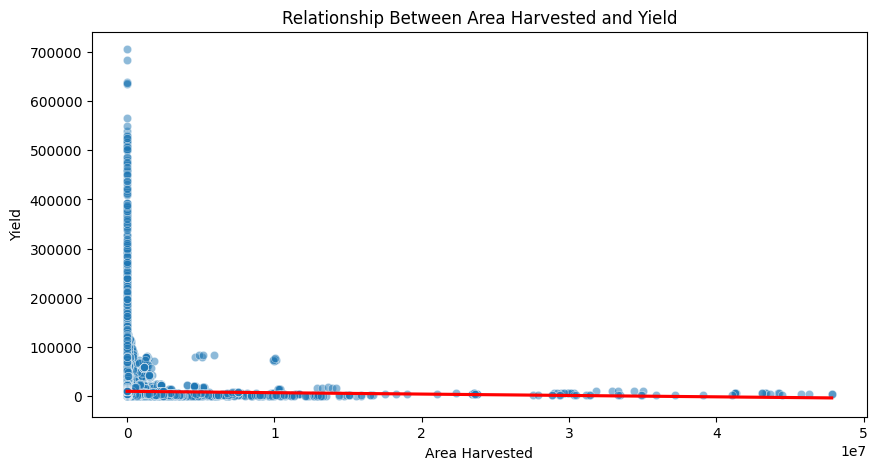

In [4]:
# Environmental Relationships Analysis 
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x="Area harvested", y="Yield", alpha=0.5)  # Scatter plot
sns.regplot(data=df, x="Area harvested", y="Yield", scatter=False, color="red")  # Regression line

plt.xlabel("Area Harvested")
plt.ylabel("Yield")
plt.title("Relationship Between Area Harvested and Yield")
plt.show()

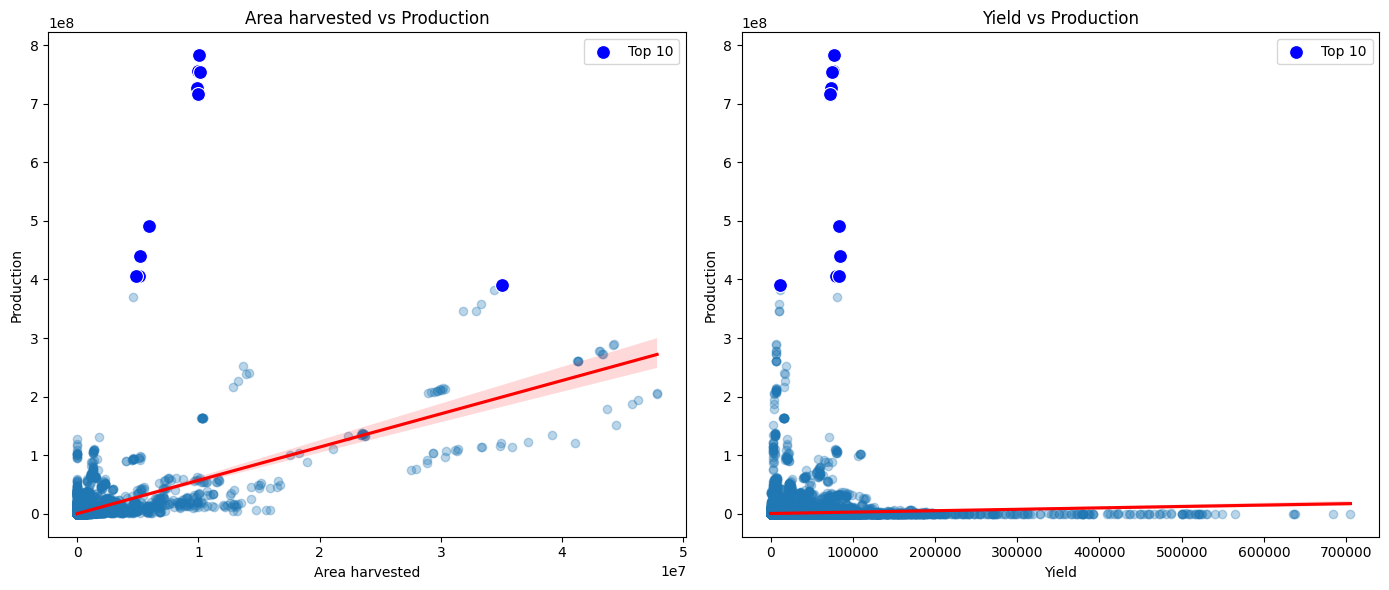

Element,Domain,Area,Item,Year,Area harvested,Production,Yield
9815,Crops and livestock products,Brazil,Sugar cane,2023,10065599.0,782585836.0,77748.6
9812,Crops and livestock products,Brazil,Sugar cane,2020,9996134.0,756070576.0,75636.3
9811,Crops and livestock products,Brazil,Sugar cane,2019,10092430.0,753470465.0,74657.0
9814,Crops and livestock products,Brazil,Sugar cane,2022,9886621.0,726052712.0,73437.9
9813,Crops and livestock products,Brazil,Sugar cane,2021,9971370.0,715679276.0,71773.4
38913,Crops and livestock products,India,Sugar cane,2023,5885317.0,490533351.1,83348.7
38912,Crops and livestock products,India,Sugar cane,2022,5175410.0,439424890.0,84906.3
38909,Crops and livestock products,India,Sugar cane,2019,5061090.0,405416180.0,80104.5
38911,Crops and livestock products,India,Sugar cane,2021,4851230.0,405398710.0,83566.2
91815,Crops and livestock products,United States of America,Maize (corn),2023,35010950.0,389694460.0,11130.6


In [5]:
# Get the top 10 rows with the highest Production values
top_10_production = df.nlargest(10, 'Production')

# Plot with highlighted top 10 points
plt.figure(figsize=(14, 6))

# Area harvested vs Production
plt.subplot(1, 2, 1)
sns.regplot(x='Area harvested', y='Production', data=df, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
sns.scatterplot(x='Area harvested', y='Production', data=top_10_production, color='blue', s=100, label='Top 10')
plt.title('Area harvested vs Production')
plt.legend()

# Yield vs Production
plt.subplot(1, 2, 2)
sns.regplot(x='Yield', y='Production', data=df, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
sns.scatterplot(x='Yield', y='Production', data=top_10_production, color='blue', s=100, label='Top 10')
plt.title('Yield vs Production')
plt.legend()

plt.tight_layout()
plt.show()

# Display the top 10 records
top_10_production

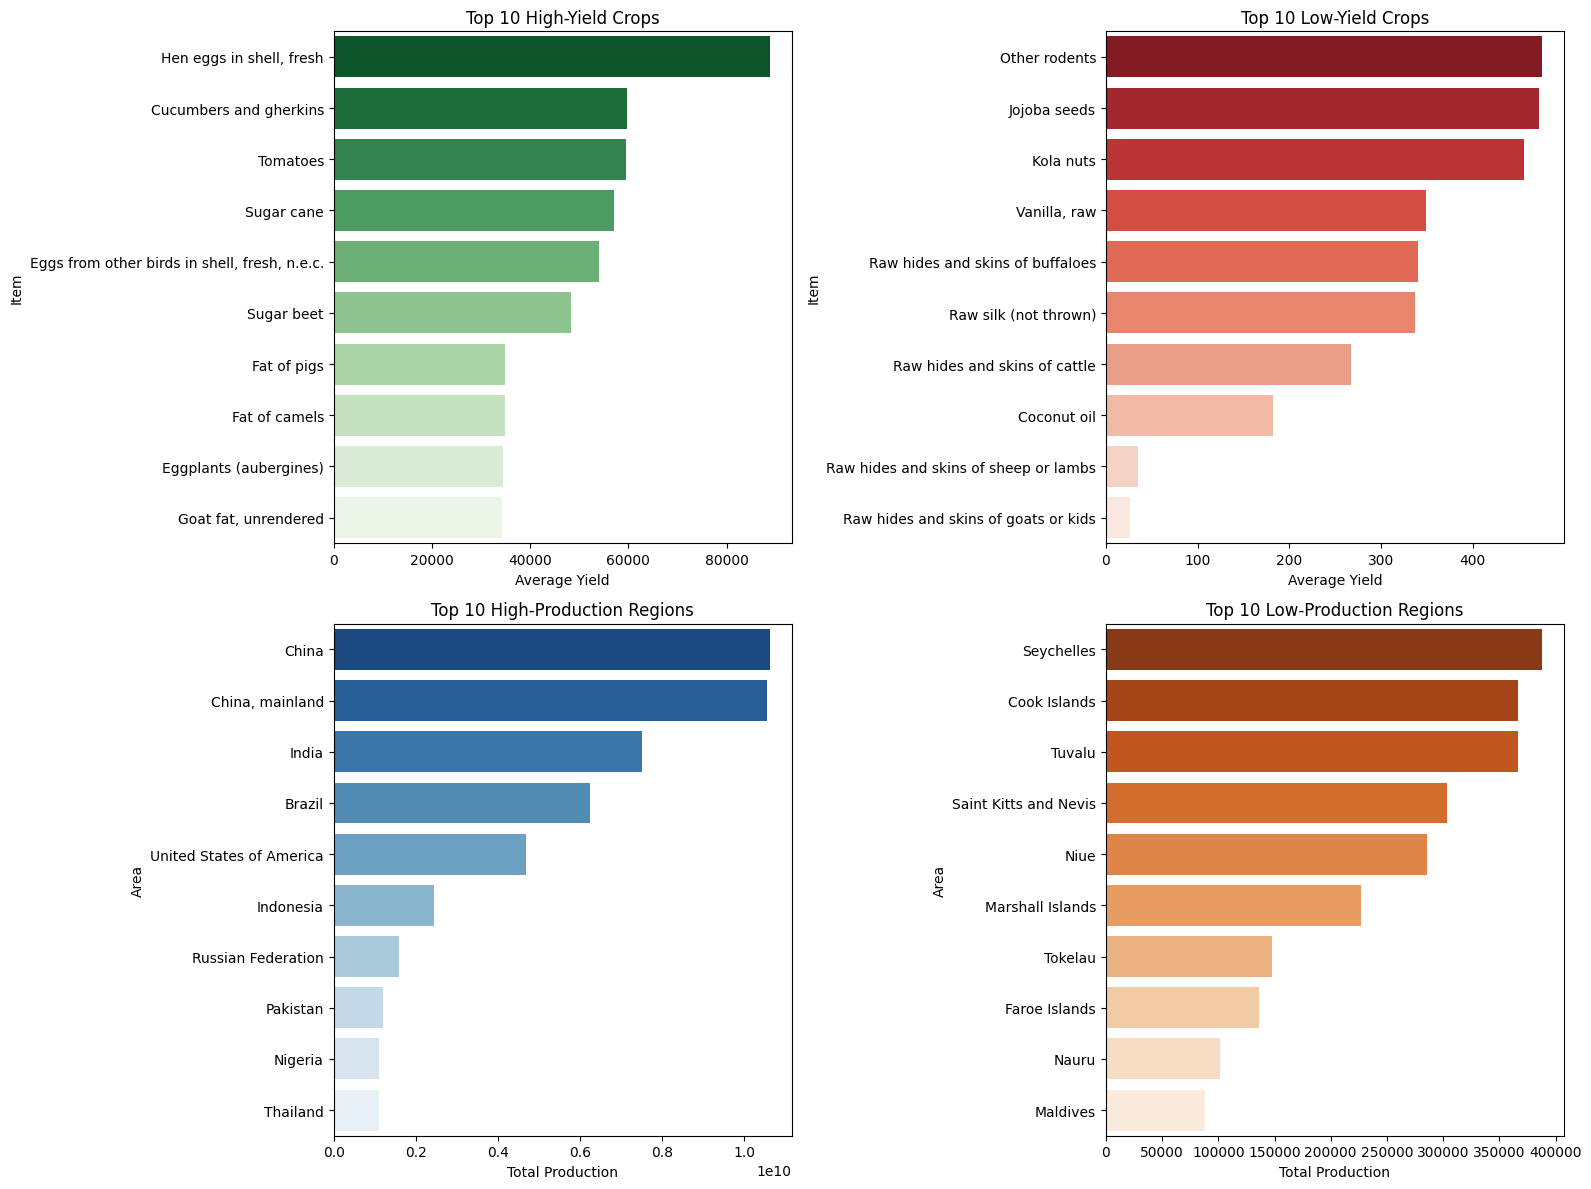

In [6]:
# Comparative Analysis: Across Crops (Yield comparison)

# Average yield by crop (Item)
crop_yield = df.groupby('Item')['Yield'].mean().sort_values(ascending=False)

# Top 10 high-yield and low-yield crops
top_10_yield_crops = crop_yield.head(10)
bottom_10_yield_crops = crop_yield.tail(10)

# Total production by area (Region)
area_production = df.groupby('Area')['Production'].sum().sort_values(ascending=False)

# Top 10 high-production and low-production regions
top_10_production_areas = area_production.head(10)
bottom_10_production_areas = area_production.tail(10)

# Combined visualization
plt.figure(figsize=(16, 12))

# Top 10 High-Yield Crops
plt.subplot(2, 2, 1)
sns.barplot(x=top_10_yield_crops.values, y=top_10_yield_crops.index, hue=top_10_yield_crops.index, palette='Greens_r', legend=False)
plt.title('Top 10 High-Yield Crops')
plt.xlabel('Average Yield')

# Top 10 Low-Yield Crops
plt.subplot(2, 2, 2)
sns.barplot(x=bottom_10_yield_crops.values, y=bottom_10_yield_crops.index, hue=bottom_10_yield_crops.index, palette='Reds_r', legend=False)
plt.title('Top 10 Low-Yield Crops')
plt.xlabel('Average Yield')

# Top 10 High-Production Regions
plt.subplot(2, 2, 3)
sns.barplot(x=top_10_production_areas.values, y=top_10_production_areas.index, hue=top_10_production_areas.index, palette='Blues_r', legend=False)
plt.title('Top 10 High-Production Regions')
plt.xlabel('Total Production')

# Top 10 Low-Production Regions
plt.subplot(2, 2, 4)
sns.barplot(x=bottom_10_production_areas.values, y=bottom_10_production_areas.index, hue=bottom_10_production_areas.index, palette='Oranges_r', legend=False)
plt.title('Top 10 Low-Production Regions')
plt.xlabel('Total Production')

plt.tight_layout()
plt.show()


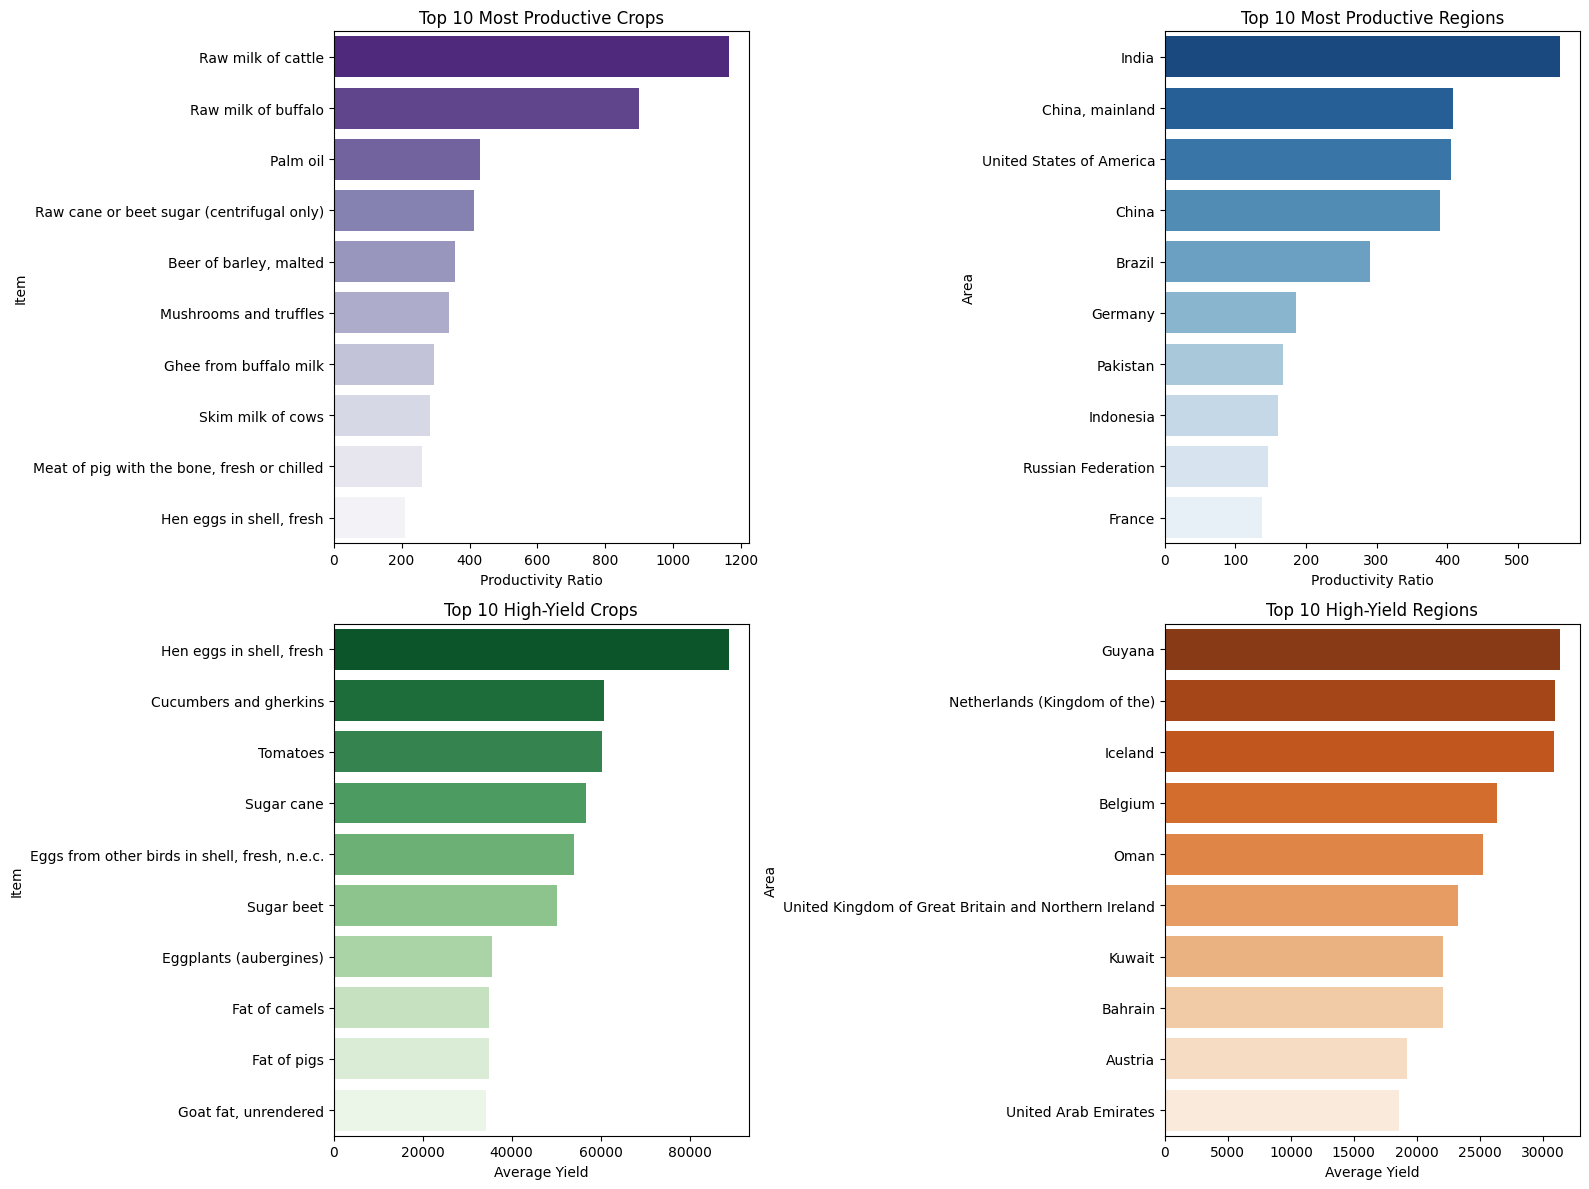

In [7]:
# Productivity Analysis

# Clean data and calculate productivity ratio
df = df[df['Area harvested'] > 0]
df['Productivity Ratio'] = df['Production'] / df['Area harvested']

# Top 10 productive crops and regions
top_10_productive_crops = df.groupby('Item')['Productivity Ratio'].mean().sort_values(ascending=False).head(10)
top_10_productive_regions = df.groupby('Area')['Productivity Ratio'].mean().sort_values(ascending=False).head(10)

# Top 10 high-yield crops and regions
top_10_yield_crops = df.groupby('Item')['Yield'].mean().sort_values(ascending=False).head(10)
top_10_yield_regions = df.groupby('Area')['Yield'].mean().sort_values(ascending=False).head(10)

# Combined plots
plt.figure(figsize=(16, 12))

# Top 10 productive crops
plt.subplot(2, 2, 1)
sns.barplot(x=top_10_productive_crops.values, y=top_10_productive_crops.index, hue=top_10_productive_crops.index, palette='Purples_r', legend=False)
plt.title('Top 10 Most Productive Crops')
plt.xlabel('Productivity Ratio')

# Top 10 productive regions
plt.subplot(2, 2, 2)
sns.barplot(x=top_10_productive_regions.values, y=top_10_productive_regions.index, hue=top_10_productive_regions.index, palette='Blues_r', legend=False)
plt.title('Top 10 Most Productive Regions')
plt.xlabel('Productivity Ratio')

# Top 10 high-yield crops
plt.subplot(2, 2, 3)
sns.barplot(x=top_10_yield_crops.values, y=top_10_yield_crops.index, hue=top_10_yield_crops.index, palette='Greens_r', legend=False)
plt.title('Top 10 High-Yield Crops')
plt.xlabel('Average Yield')

# Top 10 high-yield regions
plt.subplot(2, 2, 4)
sns.barplot(x=top_10_yield_regions.values, y=top_10_yield_regions.index, hue=top_10_yield_regions.index, palette='Oranges_r', legend=False)
plt.title('Top 10 High-Yield Regions')
plt.xlabel('Average Yield')

plt.tight_layout()
plt.show()


Number of outliers in Yield: 11399
Number of outliers in Production: 15835
Number of outliers in Area harvested: 38500


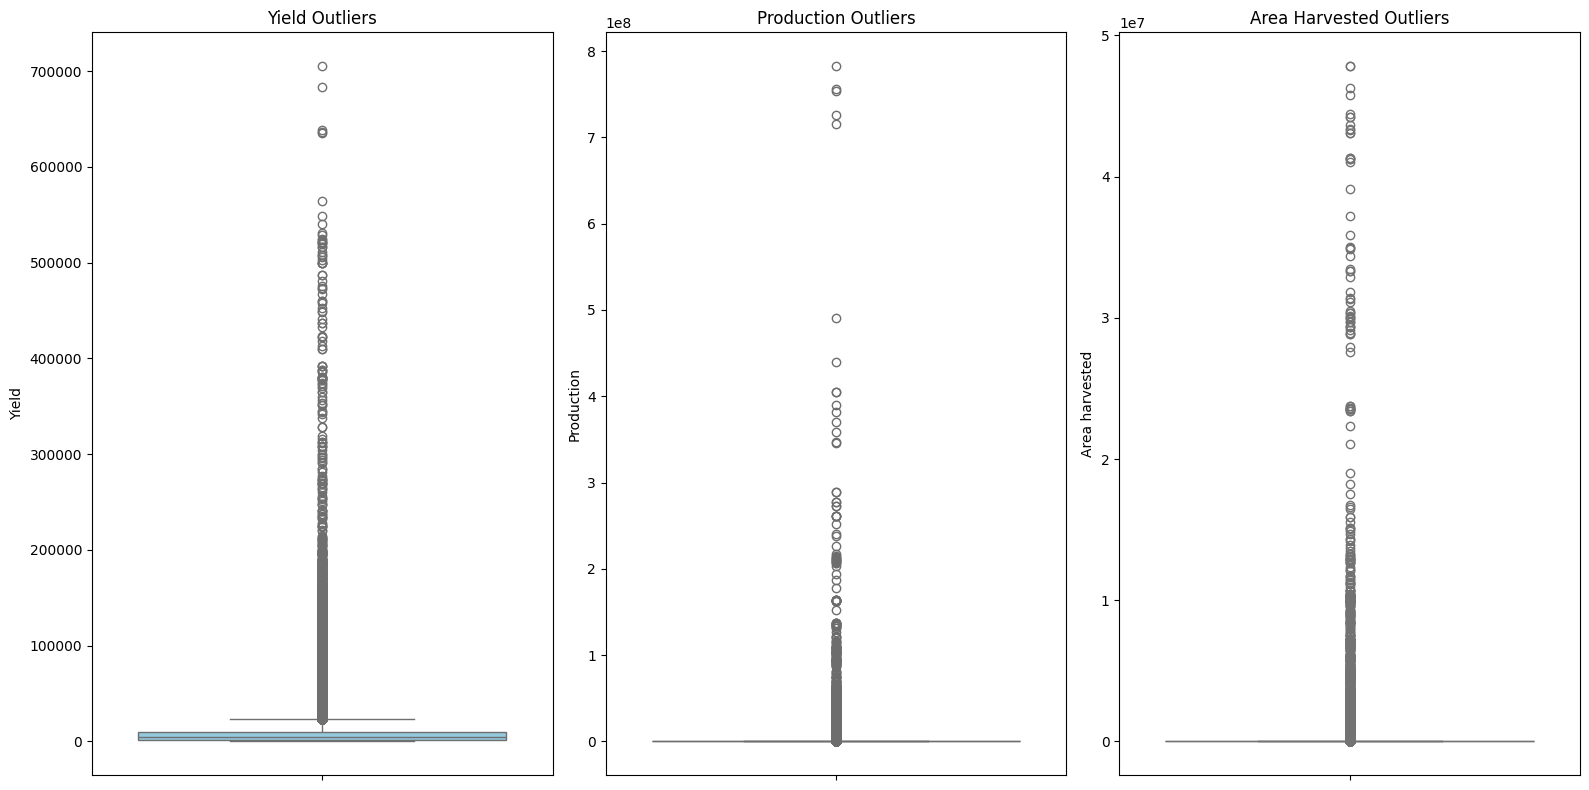

In [8]:
# Outlier Detection

# Calculate IQR for Yield, Production, and Area harvested
Q1 = df[['Yield', 'Production', 'Area harvested']].quantile(0.25)
Q3 = df[['Yield', 'Production', 'Area harvested']].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_yield = df[(df['Yield'] < lower_bound['Yield']) | (df['Yield'] > upper_bound['Yield'])]
outliers_production = df[(df['Production'] < lower_bound['Production']) | (df['Production'] > upper_bound['Production'])]
outliers_area_harvested = df[(df['Area harvested'] < lower_bound['Area harvested']) | (df['Area harvested'] > upper_bound['Area harvested'])]

# Count outliers
print("Number of outliers in Yield:", len(outliers_yield))
print("Number of outliers in Production:", len(outliers_production))
print("Number of outliers in Area harvested:", len(outliers_area_harvested))

# Box plots to visualize outliers
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['Yield'], color='skyblue')
plt.title('Yield Outliers')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['Production'], color='salmon')
plt.title('Production Outliers')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['Area harvested'], color='lightgreen')
plt.title('Area Harvested Outliers')

plt.tight_layout()
plt.show()

In [9]:
# Encode categorical variables using Label Encoding
label_encoders = {}
categorical_cols = ["Domain", "Area", "Item"]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for inverse transformation if needed

# Define features (X) and target variable (y)
X = df.drop(columns=["Production"])  # Features
y = df["Production"]  # Target variable

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for Randomized Search
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,  # Number of different combinations to try
    scoring="r2",
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best Parameters:", best_params)
print("Best R² Score from Cross-Validation:", best_score)

# Train final model with best parameters
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Make predictions
y_pred = best_rf.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Final Model Performance on Test Set:")
print("RMSE:", rmse)
print("R² Score:", r2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best R² Score from Cross-Validation: 0.9522616498503439
Final Model Performance on Test Set:
RMSE: 1400478.641759344
R² Score: 0.984960456793134


In [10]:
from sklearn.metrics import mean_absolute_error
mae = np.sqrt(mean_absolute_error(y_test, y_pred))
print("mae:", mae)

mae: 193.24042753663934


In [13]:
import pandas as pd
import mysql.connector
from mysql.connector import Error

# MySQL Connection Details
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="aji",
    database= "CropDatabase",
    auth_plugin="mysql_native_password"
)

print("Connected to MySQL:", db)

mycursor = db.cursor()

# Load the cleaned dataset
df = pd.read_csv('Updated_data.csv')

# Convert dataframe to a list of tuples for batch insertion
data = df.to_records(index=False).tolist()

# Define batch size for efficient inserts
BATCH_SIZE = 1000  # Adjust based on performance

try:
    # Disable keys for faster inserts
    mycursor.execute("ALTER TABLE CropData DISABLE KEYS;")
    db.commit()

    # SQL query for inserting data
    sql = """INSERT INTO CropData (Domain, Area, Item, Year, `Area harvested`,`Production`, `Yield`)
             VALUES (%s, %s, %s, %s, %s, %s, %s)"""

    # Batch insert using executemany()
    total_records = len(data)
    for i in range(0, total_records, BATCH_SIZE):
        batch = data[i:i+BATCH_SIZE]
        mycursor.executemany(sql, batch)
        db.commit()  # Commit after each batch

        # Progress Tracking
        print(f"Inserted {i + len(batch)} / {total_records} records...")

    # Enable keys after inserting data
    mycursor.execute("ALTER TABLE CropData ENABLE KEYS;")
    db.commit()

    print("Large dataset uploaded successfully to MySQL.")

except Error as e:
    print(f"Error: {e}")

finally:
    mycursor.close()
    db.close()
    print("MySQL connection closed.")


Connected to MySQL: <mysql.connector.connection.MySQLConnection object at 0x000001FD10A92710>
Inserted 1000 / 95927 records...
Inserted 2000 / 95927 records...
Inserted 3000 / 95927 records...
Inserted 4000 / 95927 records...
Inserted 5000 / 95927 records...
Inserted 6000 / 95927 records...
Inserted 7000 / 95927 records...
Inserted 8000 / 95927 records...
Inserted 9000 / 95927 records...
Inserted 10000 / 95927 records...
Inserted 11000 / 95927 records...
Inserted 12000 / 95927 records...
Inserted 13000 / 95927 records...
Inserted 14000 / 95927 records...
Inserted 15000 / 95927 records...
Inserted 16000 / 95927 records...
Inserted 17000 / 95927 records...
Inserted 18000 / 95927 records...
Inserted 19000 / 95927 records...
Inserted 20000 / 95927 records...
Inserted 21000 / 95927 records...
Inserted 22000 / 95927 records...
Inserted 23000 / 95927 records...
Inserted 24000 / 95927 records...
Inserted 25000 / 95927 records...
Inserted 26000 / 95927 records...
Inserted 27000 / 95927 records.